In [1]:
import polars as pl
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt

DATA_CALGARY_PATH = Path("data/calgary_2017_2021.parquet")
SOCRATA_API = ""

In [2]:
def load_data_calgary() -> pl.DataFrame:
    """
    Loads data from saved parquet if available, otherwise uses api key to query for that info via sodapy
    :return:
    """
    if not DATA_CALGARY_PATH.exists():
        from sodapy import Socrata
        client = Socrata("data.calgary.ca", SOCRATA_API)
        results = client.get("6zp6-pxei",  limit=3_000_000)
        results_df = pl.from_records(results, infer_schema_length=2000)
        results_df = results_df.with_columns(pl.col("roll_year").str.strptime(pl.Date, fmt='%Y').cast(pl.Datetime))
        filtered_df = results_df.filter((pl.col("roll_year").is_between(datetime(2017, 1, 1), datetime(2021,1,1))))
        filtered_df.write_parquet(DATA_CALGARY_PATH)
    else:
        filtered_df = pl.read_parquet(DATA_CALGARY_PATH, )
    return filtered_df

calgary_df = load_data_calgary()

In [4]:
# sample_df = calgary_df.sample(frac=0.3, seed=42)
# print(len(sample_df))

# Focus only on residential properties
prior_len = len(calgary_df)
calgary_df = calgary_df.filter(pl.col("assessment_class") == "RE")
latter_len = len(calgary_df)
print(f"Filtered out {prior_len - latter_len} non-residential properties")

prior_len = len(calgary_df)
# Drop properties with no assessed value
calgary_df = calgary_df.drop_nulls("re_assessed_value")
latter_len = len(calgary_df)
print(f"Filtered out {prior_len - latter_len} properties with no assessed value")

# Drop Roll Number and other columns as it carries no real value for our analysis
column_drop_list = [
    "roll_number",
    "sub_property_use",
    "point",
    "land_size_sf",
    "land_size_ac",
    "unique_key",
    "comm_name",
    "assessment_class_description",
    "address",
    "nr_assessed_value",
    "re_assessed_value",
    "land_use_designation",
    "fl_assessed_value"
]

calgary_df = calgary_df.drop(column_drop_list)

Filtered out 111350 non-residential properties
Filtered out 1003 properties with no assessed value


In [5]:
print(f"Left over columns in the dataset: {calgary_df.columns}")
print(f"Total number of rows in dataset: {len(calgary_df):,}")
print(f"Total number of columns in dataset: {len(calgary_df.columns):,}")

Left over columns in the dataset: ['roll_year', 'assessed_value', 'assessment_class', 'comm_code', 'latitude', 'longitude', 'year_of_construction', 'property_type', 'land_size_sm']
Total number of rows in dataset: 2,320,076
Total number of columns in dataset: 9


In [6]:
# Drop any rows with null/na values for our variables of interest (y)
prior_len = len(calgary_df)
calgary_df = calgary_df.drop_nulls("assessed_value")
print(f"Filtered out {prior_len - len(calgary_df)} properties with no assessed value")

# Drop any rows with null/na values for our variables on x side
prior_len = len(calgary_df)
col_list = ["land_size_sm", "roll_year", "comm_code", "year_of_construction", "property_type", "assessment_class", "latitude", "longitude"]
calgary_df = calgary_df.drop_nulls(col_list)
print(f"Filtered out {prior_len - len(calgary_df):,} properties with na/null values in specified columns\nLeft Over Rows: {len(calgary_df):,}")

Filtered out 0 properties with no assessed value
Filtered out 1,515,068 properties with na/null values in specified columns
Left Over Rows: 805,008


In [7]:
# Cast columns to the correct types: 
calgary_df = calgary_df.with_columns(pl.col(["assessed_value", "year_of_construction"]).cast(pl.Int32))
calgary_df = calgary_df.with_columns(pl.col("land_size_sm").cast(pl.Float64))
calgary_df = calgary_df.with_columns(pl.col(["longitude", "latitude"]).cast(pl.Float64))

In [8]:
import mpu

def cal_distance_from_center(lat, long):
    lat_cal_center, long_cal_center = 51.047956, -114.068913
    return mpu.haversine_distance((lat, long), (lat_cal_center, long_cal_center))
    
def quadrant(lat, long):
    # Longitude increase as we go further north
    # Latitude increase as we go further east
    # Therefore, if lat is greater than lat_cal_center, we are in the north quadrant
    # &, if long is greater than long_cal_center, we are in the east quadrant
    lat_cal_center, long_cal_center = 51.047956, -114.068913
    NS = "N" if lat > lat_cal_center else "S"
    EW = "E" if long > long_cal_center else "W"
    
    return NS + EW


In [9]:
# Feature engineer for latitude & longtitude -
# Distance from the center of the city as a float value
calgary_df = calgary_df.with_columns(
    calgary_df.select(
        pl.struct(["latitude", "longitude"]).apply(lambda x: cal_distance_from_center(x["latitude"], x["longitude"]), pl.Float64).alias("distance_from_center")
    )
)

# feature engineer (future) - > define quadrants (ne, nw, se, sw) for the city as an addtiional feature based on longitutde and latitude

calgary_df = calgary_df.with_columns(
    calgary_df.select(
        pl.struct(
            ["latitude", "longitude"]
        ).apply(lambda x: quadrant(x["latitude"], x["longitude"]), pl.Utf8).alias("quadrant")
    )   
)

In [10]:
calgary_df.head()

roll_year,assessed_value,assessment_class,comm_code,latitude,longitude,year_of_construction,property_type,land_size_sm,distance_from_center,quadrant
datetime[μs],i32,str,str,f64,f64,i32,str,f64,f64,str
2021-01-01 00:00:00,406500,"""RE""","""SAD""",51.127365,-113.949156,2000,"""LI""",353.9,12.162644,"""NE"""
2021-01-01 00:00:00,1080000,"""RE""","""EDG""",51.118489,-114.14213,1985,"""LI""",930.2,9.363092,"""NW"""
2021-01-01 00:00:00,670000,"""RE""","""SIL""",51.114289,-114.198913,1988,"""LI""",827.8,11.699148,"""NW"""
2021-01-01 00:00:00,640000,"""RE""","""VAR""",51.098566,-114.159969,1966,"""LI""",612.5,8.493606,"""NW"""
2021-01-01 00:00:00,465000,"""RE""","""THO""",51.109854,-114.076038,1975,"""LI""",531.0,6.900713,"""NW"""


In [11]:
out = calgary_df.select(
    [
        pl.col("property_type").n_unique().alias("Property Type Count (Unique)"),
        pl.col("comm_code").n_unique().alias("Community Code Count (Unique)"),
    ]
)
print(out.head())


shape: (1, 2)
┌──────────────────────────────┬───────────────────────────────┐
│ Property Type Count (Unique) ┆ Community Code Count (Unique) │
│ ---                          ┆ ---                           │
│ u32                          ┆ u32                           │
╞══════════════════════════════╪═══════════════════════════════╡
│ 2                            ┆ 251                           │
└──────────────────────────────┴───────────────────────────────┘


shape: (251, 2)
┌───────────┬───────┐
│ comm_code ┆ Count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ BLN       ┆ 25738 │
│ EVE       ┆ 13718 │
│ SIG       ┆ 12152 │
│ PAN       ┆ 12118 │
│ …         ┆ …     │
│ 13E       ┆ 1     │
│ 13J       ┆ 1     │
│ 12I       ┆ 1     │
│ 01C       ┆ 1     │
└───────────┴───────┘


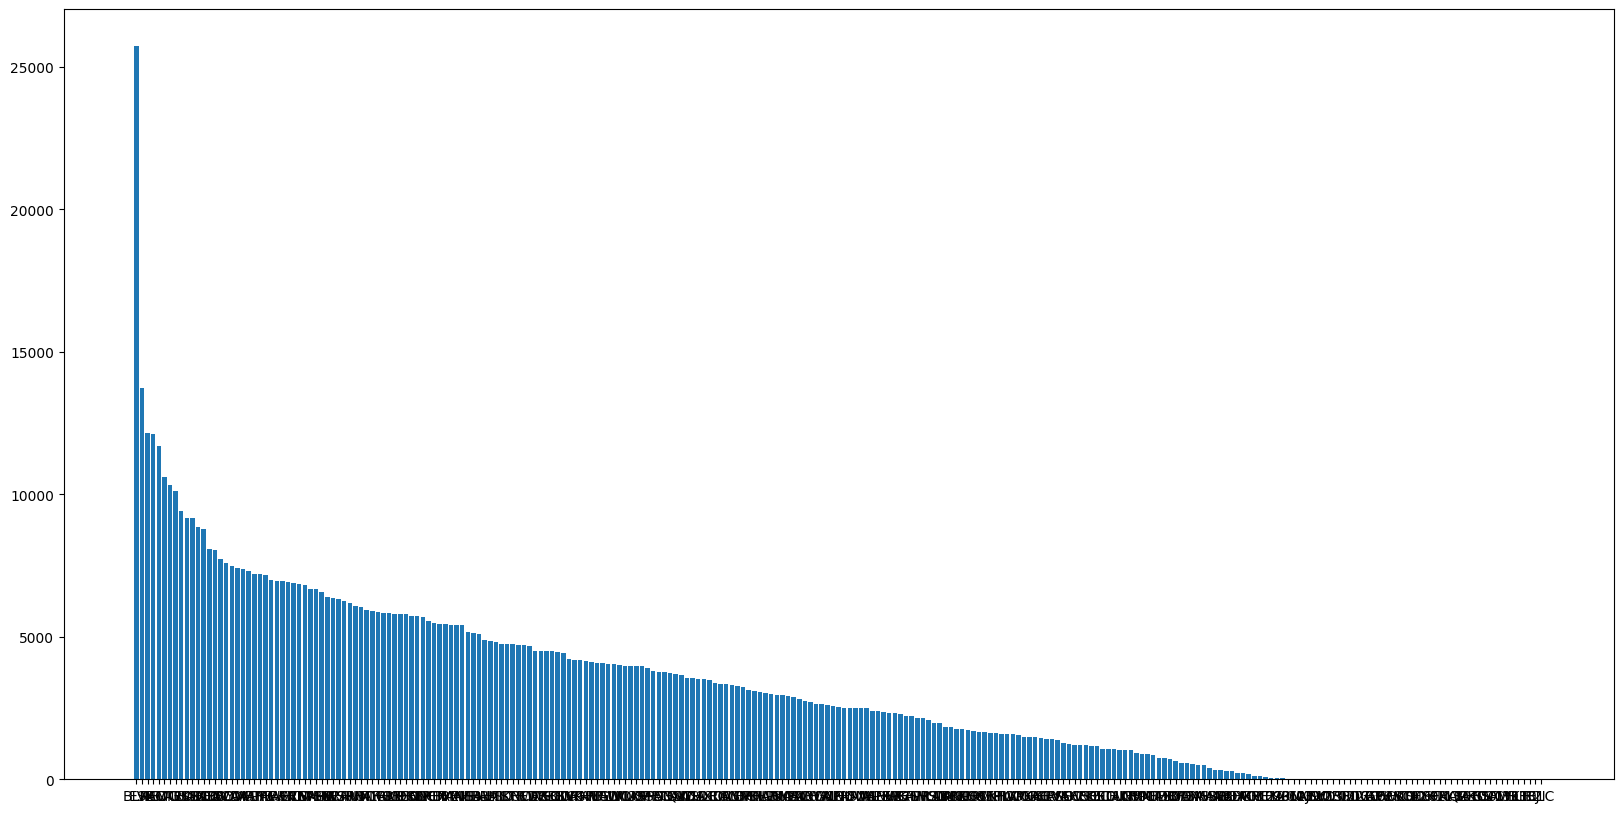

In [12]:
comm_codes_counts = calgary_df.groupby("comm_code").agg(
    [
        pl.count().alias("Count"),
    ]
).sort("Count", descending=True)
plt.figure(figsize=(20, 10))
plt.bar(
    x = comm_codes_counts["comm_code"].to_numpy(),
    height=comm_codes_counts["Count"].to_numpy()
)
print(comm_codes_counts)

In [13]:
# Based on the above graph, we will set the threshold to 5000 and see how many communities we can retain in our analysis
def map_community(comm_code):
    if comm_code in comm_codes_counts.filter(pl.col("Count") > 5000)["comm_code"].to_list():
        return comm_code
    else:
        return "Other"

In [14]:
calgary_df = calgary_df.with_columns(
    calgary_df.select(
        pl.struct(
            ["comm_code"]
        ).apply(lambda x: map_community(x["comm_code"]), pl.Utf8).alias("comm_code")
    )   
)

In [15]:
counts_comm = calgary_df.groupby("comm_code").agg(pl.count().alias("Count")).sort("Count", descending=True)
print(counts_comm)
# So noew we are left with 63 communities, which is a good number to work with for our analysis

shape: (63, 2)
┌───────────┬────────┐
│ comm_code ┆ Count  │
│ ---       ┆ ---    │
│ str       ┆ u32    │
╞═══════════╪════════╡
│ Other     ┆ 340952 │
│ BLN       ┆ 25738  │
│ EVE       ┆ 13718  │
│ SIG       ┆ 12152  │
│ …         ┆ …      │
│ MIS       ┆ 5416   │
│ NEB       ┆ 5184   │
│ MRL       ┆ 5147   │
│ EAU       ┆ 5091   │
└───────────┴────────┘


In [16]:
calgary_df.groupby("assessment_class").agg(pl.count().alias("Count")).sort("Count", descending=True)

assessment_class,Count
str,u32
"""RE""",805008


In [17]:
# Lets drop the assessment_class variable as it has only one value 
calgary_df = calgary_df.drop("assessment_class")

In [18]:
calgary_df.groupby("property_type").agg(pl.count().alias("Count")).sort("Count", descending=True)

property_type,Count
str,u32
"""LI""",804988
"""LO""",20


In [19]:
# As we can see, there are only 20 proepties with the LO type property_type,  as such, we can drop those tags as well.
calgary_df = calgary_df.filter(pl.col("property_type") != "LO")
calgary_df = calgary_df.drop("property_type")

In [20]:
calgary_df

roll_year,assessed_value,comm_code,latitude,longitude,year_of_construction,land_size_sm,distance_from_center,quadrant
datetime[μs],i32,str,f64,f64,i32,f64,f64,str
2021-01-01 00:00:00,406500,"""SAD""",51.127365,-113.949156,2000,353.9,12.162644,"""NE"""
2021-01-01 00:00:00,1080000,"""EDG""",51.118489,-114.14213,1985,930.2,9.363092,"""NW"""
2021-01-01 00:00:00,670000,"""SIL""",51.114289,-114.198913,1988,827.8,11.699148,"""NW"""
2021-01-01 00:00:00,640000,"""VAR""",51.098566,-114.159969,1966,612.5,8.493606,"""NW"""
2021-01-01 00:00:00,465000,"""THO""",51.109854,-114.076038,1975,531.0,6.900713,"""NW"""
2021-01-01 00:00:00,303500,"""Other""",51.108405,-113.954929,1981,278.5,10.420515,"""NE"""
2021-01-01 00:00:00,595000,"""Other""",51.093539,-114.12116,1964,690.1,6.246328,"""NW"""
2021-01-01 00:00:00,650000,"""VAR""",51.088546,-114.14943,1968,668.3,7.212713,"""NW"""
2021-01-01 00:00:00,174000,"""VAR""",51.086176,-114.159663,1978,10451.3,7.633614,"""NW"""


In [21]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

In [22]:
# lets build our pre-processing pipeline! 
calgary_df = calgary_df.with_columns(pl.col("roll_year").dt.year().alias("roll_year"))
# sample to reduce the training load on our puny computer
calgary_df = calgary_df.sample(frac=0.3, with_replacement=False, seed=42)
y = calgary_df["assessed_value"].to_pandas()
X = calgary_df.drop("assessed_value").to_pandas()

In [23]:
X.dtypes

roll_year                 int32
comm_code                object
latitude                float64
longitude               float64
year_of_construction      int32
land_size_sm            float64
distance_from_center    float64
quadrant                 object
dtype: object

In [51]:
ct = ColumnTransformer(
    [
        ("one_hot_commc_code", OneHotEncoder(), ["comm_code"]),
        ("one_hot_quadrant", OneHotEncoder(), ["quadrant"]),
        ("std_scaler_land_size", StandardScaler(), ["land_size_sm"]),
        ("std_scaler_distance_from_center", StandardScaler(), ["distance_from_center"]),
    ],
    remainder="passthrough",
)

rgr = Pipeline(
    steps=[("preprocessor", ct), ("regressor", RandomForestRegressor(random_state=42))]
)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rgr.fit(X_train, y_train)
# rgr.score(X_test, y_test)

cross_val_score(rgr, X, y, cv=5, scoring="neg_root_mean_squared_error")

array([ -676926.59101683,  -483130.25756371, -1022794.93979615,
        -517590.35542385, -1021379.27402958])

In [25]:
ct = ColumnTransformer(
    [
        ("one_hot_commc_code", OneHotEncoder(), ["comm_code"]),
        ("one_hot_quadrant", OneHotEncoder(), ["quadrant"]),
        ("std_scaler_land_size", StandardScaler(), ["land_size_sm"]),
        ("std_scaler_distance_from_center", StandardScaler(), ["distance_from_center"]),
    ],
    remainder="passthrough",
)

rgr = Pipeline(
    steps=[("preprocessor", ct), ("regressor", GradientBoostingRegressor(random_state=42))]
)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rgr.fit(X_train, y_train)
# rgr.score(X_test, y_test)

cross_val_score(rgr, X, y, cv=5, scoring="neg_root_mean_squared_error")

array([ -664961.05656123,  -524356.0212269 , -1119354.50505842,
        -619957.42863975, -1117653.75966299])

## Preprocess Data

1. Drop columns that are not useful for the model
2. Drop rows with missing values
3. Normalize the data
4. Encode categorical columns with one-hot encoding/ ordinal encoding
5. Split the data into train and test sets